In [79]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt #for visualization
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [103]:
census_df = pd.read_csv('2010-2019 Census Data.csv')
census_df.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,NPOPCHG_2019,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,BIRTHS2019,DEATHS2010,DEATHS2011,DEATHS2012,DEATHS2013,DEATHS2014,DEATHS2015,DEATHS2016,DEATHS2017,DEATHS2018,DEATHS2019,NATURALINC2010,NATURALINC2011,NATURALINC2012,NATURALINC2013,NATURALINC2014,NATURALINC2015,NATURALINC2016,NATURALINC2017,NATURALINC2018,NATURALINC2019,INTERNATIONALMIG2010,INTERNATIONALMIG2011,INTERNATIONALMIG2012,...,RESIDUAL2014,RESIDUAL2015,RESIDUAL2016,RESIDUAL2017,RESIDUAL2018,RESIDUAL2019,RBIRTH2011,RBIRTH2012,RBIRTH2013,RBIRTH2014,RBIRTH2015,RBIRTH2016,RBIRTH2017,RBIRTH2018,RBIRTH2019,RDEATH2011,RDEATH2012,RDEATH2013,RDEATH2014,RDEATH2015,RDEATH2016,RDEATH2017,RDEATH2018,RDEATH2019,RNATURALINC2011,RNATURALINC2012,RNATURALINC2013,RNATURALINC2014,RNATURALINC2015,RNATURALINC2016,RNATURALINC2017,RNATURALINC2018,RNATURALINC2019,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RINTERNATIONALMIG2019,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,10,0,0,0,United States,308745538,308758105,309321666,311556874,313830990,315993715,318301008,320635163,322941311,324985539,326687501,328239523,563561,2235208,2274116,2162725,2307293,2334155,2306148,2044228,1701962,1552022,987836,3973485,3936976,3940576,3963195,3992376,3962654,3901982,3824521,3791712,598691,2512442,2501531,2608019,2582448,2699826,2703215,2788163,2824382,2835038,389145,1461043,1435445,1332557,1380747,1292550,1259439,1113819,1000139,956674,174416,774165,838671,...,0,0,0,0,0,0,12.799557,12.590510,12.513247,12.496383,12.496948,12.314477,12.044514,11.737546,11.579037,8.093184,7.999935,8.281730,8.142738,8.451004,8.400602,8.606413,8.668095,8.657569,4.706373,4.590575,4.231517,4.353645,4.045944,3.913875,3.438101,3.069450,2.921467,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
1,20,1,0,0,Northeast Region,55317240,55318443,55380134,55604223,55775216,55901806,56006011,56034684,56042330,56059240,56046620,55982803,61691,224089,170993,126590,104205,28673,7646,16910,-12620,-63817,163466,646249,637860,635751,632433,634504,628030,618490,610713,602740,110878,470811,460915,479963,470268,489209,480502,497919,503076,505588,52588,175438,176945,155788,162165,145295,147528,120571,107637,97152,45032,204242,205018,...,-2784,-1110,-319,-693,-615,-783,11.645767,11.453820,11.385529,11.302749,11.326313,11.207115,11.034457,10.895291,10.760387,8.484277,8.276483,8.595555,8.404560,8.732702,8.574497,8.883355,8.975017,9.025986,3.161491,3.177337,2.789974,2.898189,2.593611,2.632618,2.151103,1.920274,1.734402,3.680555,3.681434,3.428960,3.931182,4.009115,4.177449,3.809171,3.195141,2.394817,-2.792646,-3.719789,-3.898743,-4.917279,-6.071080,-6.667933,-5.646219,-5.329588,-5.254530,0.887909,-0.038355,-0.469783,-0.986097,-2.061965,-2.490484,-1.837048,-2.134447,-2.859713
2,20,2,0,0,Midwest Region,66927001,66929725,66974416,67157800,67336743,67560379,67745167,67860583,67987540,68126781,68236628,68329004,44691,183384,178943,223636,184788,115416,126957,139241,109847,92376,212570,834866,830701,830890,836538,838012,831641,818785,801587,792343,140862,586660,584671,605165,596898,626084,619187,640407,627911,622854,71708,248206,246

In [104]:
#drop unneeded columns
census_df = census_df.iloc[:, 4:17]


In [105]:
# will just do california for this notebook
california_df = census_df.iloc[9]
california_df.head()

NAME                 California
CENSUS2010POP          37253956
ESTIMATESBASE2010      37254519
POPESTIMATE2010        37319502
POPESTIMATE2011        37638369
Name: 9, dtype: object

In [106]:
#dropping two more columns
california_df=california_df.drop(['NAME','ESTIMATESBASE2010','POPESTIMATE2010'])
california_df

CENSUS2010POP      37253956
POPESTIMATE2011    37638369
POPESTIMATE2012    37948800
POPESTIMATE2013    38260787
POPESTIMATE2014    38596972
POPESTIMATE2015    38918045
POPESTIMATE2016    39167117
POPESTIMATE2017    39358497
POPESTIMATE2018    39461588
POPESTIMATE2019    39512223
Name: 9, dtype: object

In [107]:
#rename rows
california_df=california_df.rename({"CENSUS2010POP": 2010, "POPESTIMATE2011": 2011, 'POPESTIMATE2012': 2012, 'POPESTIMATE2013':2013, 
                      'POPESTIMATE2014':2014,'POPESTIMATE2015':2015, 'POPESTIMATE2016':2016, 
                      'POPESTIMATE2017':2017, 'POPESTIMATE2018':2018, 'POPESTIMATE2019':2019}, axis='index')
california_df

2010    37253956
2011    37638369
2012    37948800
2013    38260787
2014    38596972
2015    38918045
2016    39167117
2017    39358497
2018    39461588
2019    39512223
Name: 9, dtype: object

In [108]:
california_df = california_df.astype(int)

In [109]:
#train test split
#lets do 6 years of training 4 of test
training_data = california_df[0:6]

test_data = california_df[6:]
test_data


2016    39167117
2017    39358497
2018    39461588
2019    39512223
Name: 9, dtype: int32

In [110]:
#EDF

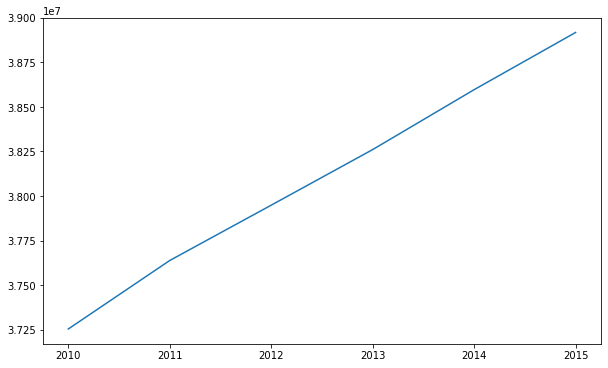

In [111]:
plt.plot(training_data)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

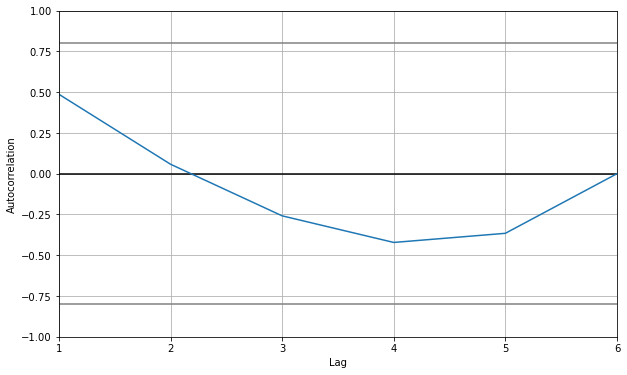

In [112]:
#auto correlation
autocorrelation_plot(training_data)

C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


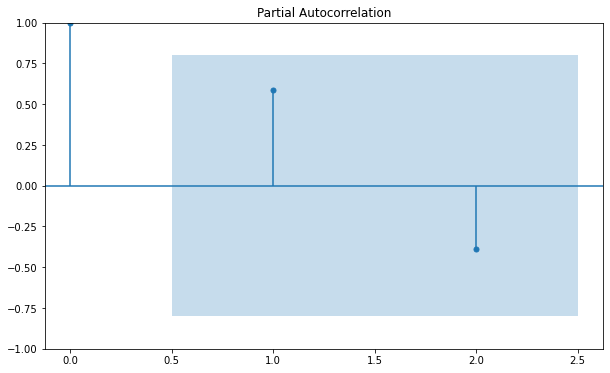

In [113]:
#partial auto correlation
plot_pacf(training_data, lags= 2)
plt.show()

In [114]:
#orders for arima model 
# 1 or 2 for p
# 2 for Q
# 0 for d

In [115]:
training_data.values

array([37253956, 37638369, 37948800, 38260787, 38596972, 38918045])

                               SARIMAX Results                                
Dep. Variable:                      9   No. Observations:                    6
Model:                 ARIMA(1, 1, 1)   Log Likelihood            -1666640.201
Date:                Mon, 11 Jul 2022   AIC                        3333286.402
Time:                        17:05:25   BIC                        3333285.230
Sample:                             0   HQIC                       3333283.257
                                  - 6                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8377   5.03e-07   1.67e+06      0.000       0.838       0.838
ma.L1          0.9796   8.02e-05   1.22e+04      0.000       0.979       0.980
sigma2      1075.8168      0.084   1.29e+04      0.0

C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.p

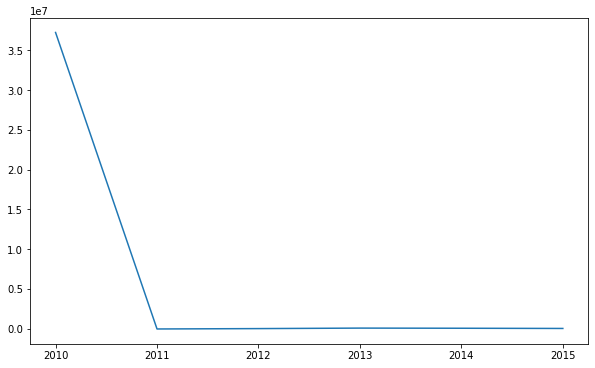

In [247]:
#arima model
model = ARIMA(training_data, order=(1,1,1))
results_AR = model.fit()
print(results_AR.summary())
residuals = results_AR.resid
residuals.plot()
plt.show()


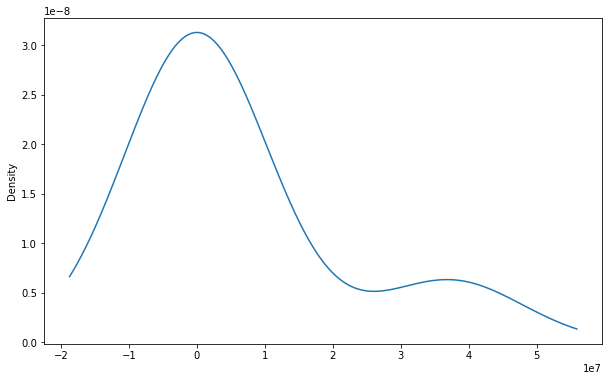

count    6.000000e+00
mean     6.216108e+06
std      1.520543e+07
min     -5.442166e+04
25%     -2.498668e+03
50%      2.428644e+04
75%      5.104580e+04
max      3.725396e+07
dtype: float64


In [248]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [249]:
#making predictions
y_pred = pd.Series(results_AR.forecast(4))
y_pred

C:\Users\djkri\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


6    3.919612e+07
7    3.942906e+07
8    3.962419e+07
9    3.978764e+07
Name: predicted_mean, dtype: float64

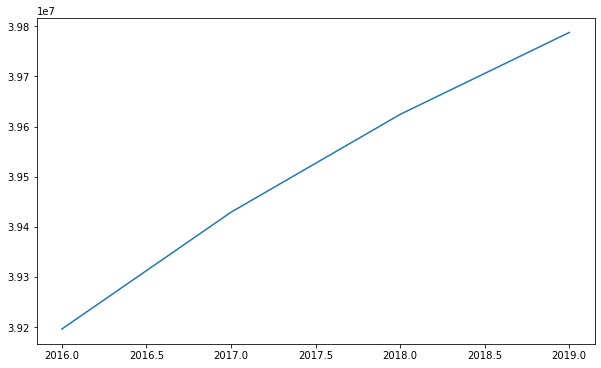

In [250]:
#rename forecast index to correct years
y_pred= y_pred.rename({6:2016, 7:2017, 8:2018, 9:2019})
y_pred.plot()
plt.show()


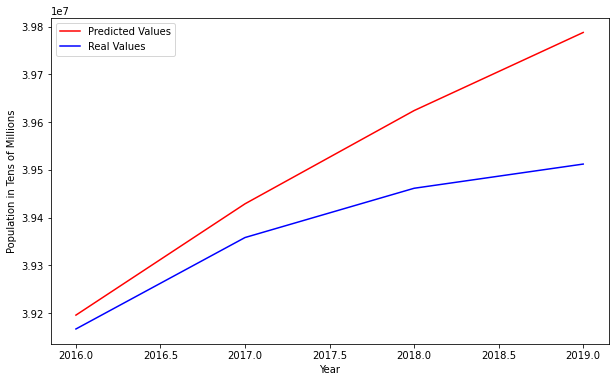

In [251]:
#now plot the model predictions and the test data
y_real = test_data
y_pred.plot(color='red', label = "Predicted Values")
y_real.plot(color='blue', label = "Real Values")
plt.xlabel("Year")
plt.ylabel('Population in Tens of Millions')
plt.legend()
plt.show()

In [252]:
# prediction analysis
#mean absolute percent error
mape = np.mean(np.abs(y_pred-y_real)/np.abs(y_real))

#mean absolute scaled error
n = training_data.shape[0]
d = np.abs(np.diff(training_data)).sum()/(n-1)
errors = np.abs(y_real - y_pred)
mase = errors.mean()/d
print(f"MAPE: {mape}",
     f"\nMASE: {mase}")

MAPE: 0.0034060783471728277 
MASE: 0.403814862162582


In [253]:
#mape and mase are good for time series as they can deal with the scale of a time series forecast better than other 
#methods of accuracy/error calculation

#mase compares the predictions of the model to a naive model, meaning a model that uses the last observed value as the value
# for all of the predictions
# a mase of 1 means that the model is just as accurate as picking the last observed value over and over as the prediction
# a mase of 0.5 means that the model is twice as accurate as the naive model


#the mape is a measure of error that is scale independent so it is useful for evaluating error of time series forecasting
#the mape is represented as a percentage
# so our mape of 0.3% should be considered a relatively good error.

In [254]:
#room for improvement for sure i think
# the plot looks kind of. you can faintly see the two elbows that are present in 
#the real values appear in the predicted graph. And at the correct years. 
# it mostly just seems like the magnitude of the values are off but the general trend of the values is there